In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics
from src.IDs import *


# Choose sample and chrom

In [4]:
focal_sample_id = "NA12879"
t2t_chrom = "chr20"
denovo_chrom = t2t_chrom + "_RagTag"



# Mix high-conf SNPs and two-sided single nuc mismatches

## Get mismatches

In [5]:
def do_it_all(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confidence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 3

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("fits1_before") >= flanking) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("fits2_before") >= flanking) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
            ),
        ]
    )
    
    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )
    
    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 1
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("qual_start1") // to_round * to_round).alias("qual_rounded"),
        )
        .group_by(["qual_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["qual_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("qual_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt
    
    

# Get them all

In [6]:
%%time 
# dfs = []
# for chrom in aut_chrom_names[1:2]:
#     print(chrom)
#     dfs.append(do_it_all(focal_sample_id, chrom + "_RagTag"))
dfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all)(focal_sample_id, chrom + "_RagTag") \
    for chrom in aut_chrom_names
    for focal_sample_id in ceph_sample_ids[:1]
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 11.3min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed: 11.4min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed: 12.2min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed: 12.5min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 20.2min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed: 20.4min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed: 20.4min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed: 20.8min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed: 26.6min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 27.1min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed: 27.3min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed: 27.4min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed: 31.6min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed: 31.7min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed: 31.9min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  16 out of  22 | elapsed: 32.0min remaining: 12.0min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  17 out of  22 | elapsed: 34.0min remaining: 10.0min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  18 out of  22 | elapsed: 34.6min remaining:  7.7min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  19 out of  22 | elapsed: 34.8min remaining:  5.5min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  20 out of  22 | elapsed: 35.6min remaining:  3.6min


/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/tmp/ipykernel_2345368/4224850719.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/4224850719.py:81: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed: 35.9min finished
CPU times: user 1.62 s, sys: 44.2 s, total: 45.8 s
Wall time: 35min 55s


# Plotting 

In [7]:
def plot_per_condition(dfs, ax, condition=None):
    if condition is None:
        condition = pl.lit(True)
        
    putative_gc_df_hap_cnt = (
        pl.concat([x.filter(condition)[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
        .group_by(["qual_rounded"])
        .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
        .sort("qual_rounded")
    )
    
    import statsmodels.stats.proportion
    A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
    B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
    p = A / B 
    lo, hi = statsmodels.stats.proportion.proportion_confint(
        A, B,
        method="beta", 
        alpha=0.05
    )

    ax.errorbar(
        x = putative_gc_df_hap_cnt["qual_rounded"],
        y = p,
        yerr = [p-lo, hi-p],
        fmt = '.'
    )

    ax.axhline(0.01, ls="--", lw=0.5, c="black")
    ax.axhline(0.1, ls="--", lw=0.5, c="black")

    ax.set_xlabel("BQ (lower threshold)");
    ax.set_ylabel("Estimated false positive rate");
    ax.set_yscale("log")
    #plt.ylim(0.95,1);


    
    

## All

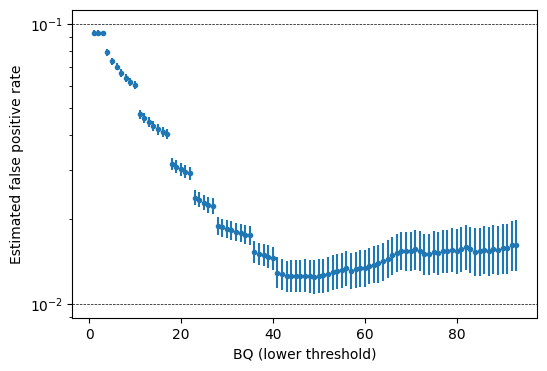

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_per_condition(dfs, ax, condition=None)

## Per sample

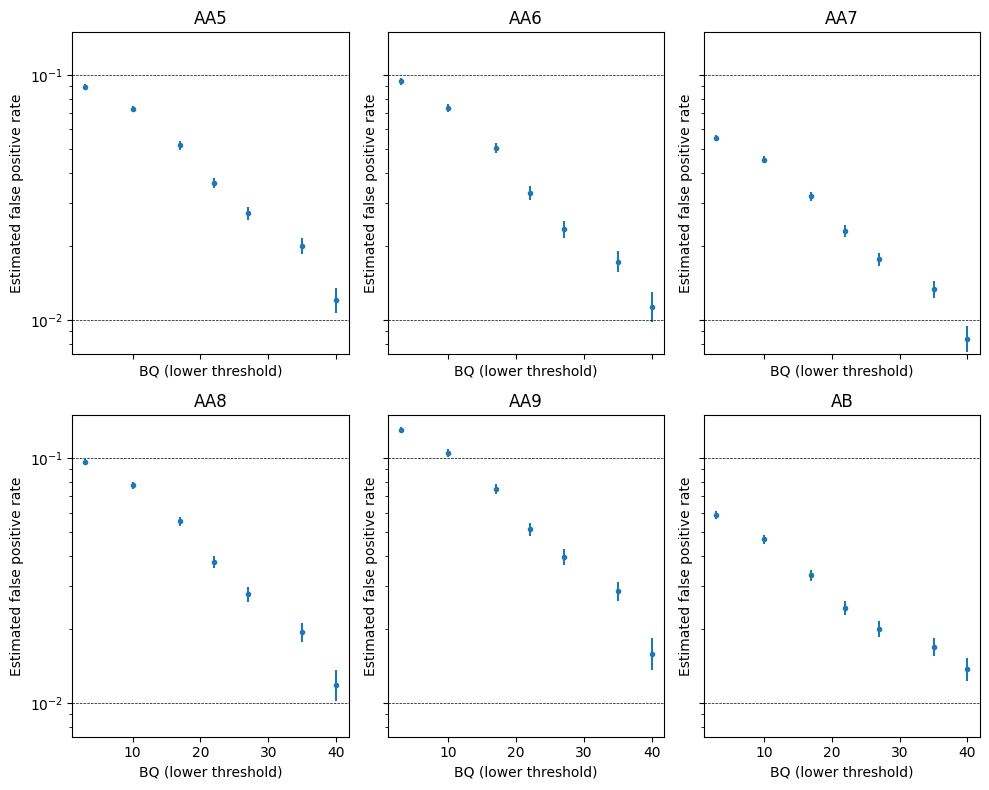

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()[:len(sudmant_sample_ids)]):
    plot_per_condition(dfs, ax, condition=(pl.col("focal_sample_id") == sudmant_sample_ids[i]))
    ax.set_title(sample_id_to_paper_label[sudmant_sample_ids[i]])

plt.tight_layout()

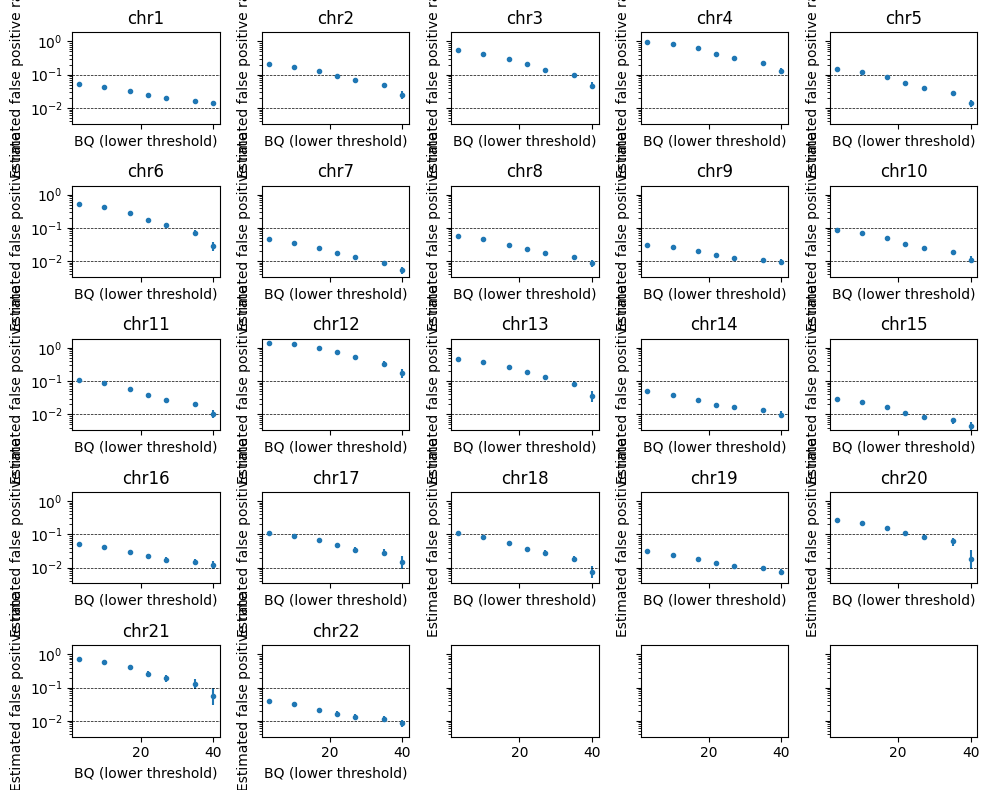

In [10]:
fig, axs = plt.subplots(5, 5, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()[:len(aut_chrom_names)]):
    plot_per_condition(dfs, ax, condition=(pl.col("chrom") == aut_chrom_names[i] + "_RagTag"))
    ax.set_title(aut_chrom_names[i])

plt.tight_layout()

# Plot it all

In [10]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
    .group_by(["qual_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
    .sort("qual_rounded")
)



CPU times: user 518 μs, sys: 4.11 ms, total: 4.63 ms
Wall time: 1.44 ms


In [11]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(putative_gc_df_hap_cnt)

qual_rounded,x_vs_y/y,x_vs_y/z,x_vs_y/x
u8,u32,u32,u32
1,121,0,3
2,38641,49,193
3,805068,1246,4766
4,293614,441,1416
5,207503,266,1063
6,158752,259,774
7,127571,186,645
8,106739,152,537
9,90896,113,493


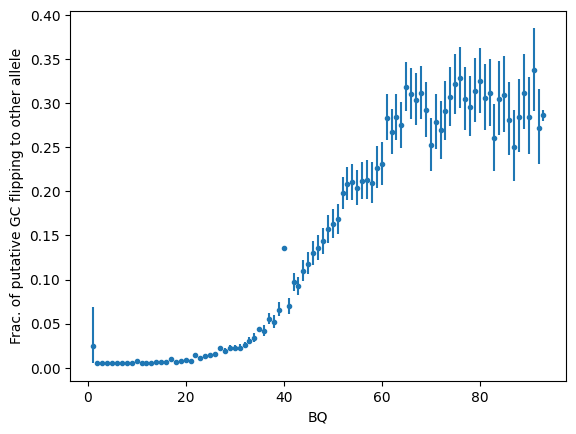

In [12]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] + putative_gc_df_hap_cnt["x_vs_y/y"]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


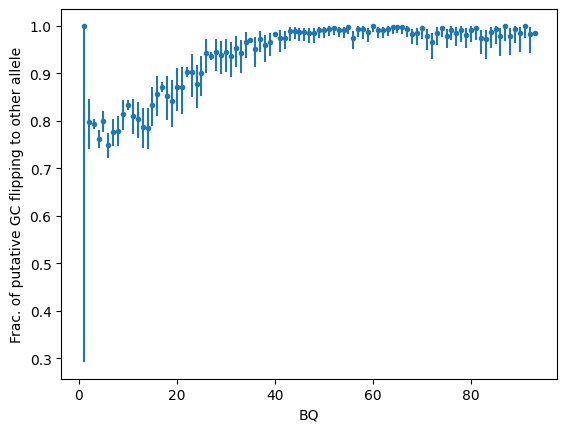

In [13]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] 
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


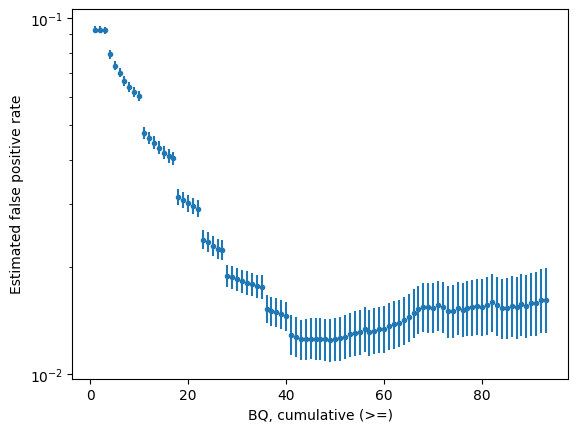

In [14]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ, cumulative (>=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
#plt.ylim(0.95,1);


# BQ as distance from start/end of read

## Read length

In [19]:
def get_read_lengths(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confidence_snps.parquet")

    read_lengths = filtered_high_conf_mismatches_df.unique(["read_name"]).select("read_length1")

    read_lengths = read_lengths.collect(streaming=True)
    
    return read_lengths


Mean: 17478.77499150923
Median: 16754.0
SE: 5042.332638112159
Quantiles 1%, 5%, 95%, 99%: [ 4663. 11758. 26569. 31484.]


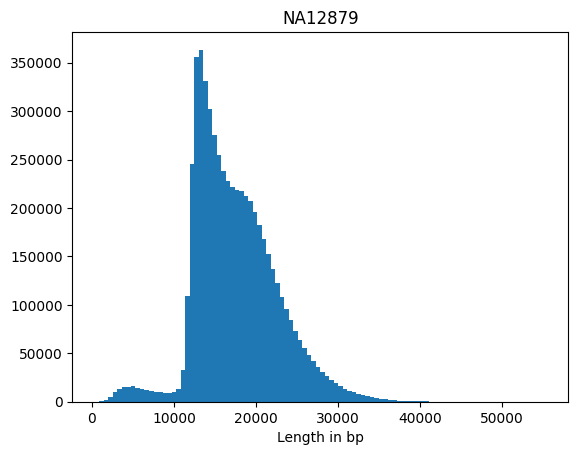

In [20]:
sample_id = "NA12879"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

## Errors at read ends

In [38]:
def do_it_all_start(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confidence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)    
    
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
                pl.col("start").cum_count().alias("snp_index"),
                pl.col("start").cum_count(reverse=True).alias("snp_rev_index"),
            )
        )
        return df

    min_mapq = 93
    context_df = (filtered_high_conf_mismatches_df
        .filter((pl.col("qual_start1") >= min_mapq) & (pl.col("qual_start2") >= min_mapq))
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 3       # including itself, if it fits
    
    display(context_df)

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits1_before") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length1") - pl.col("end")).alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits2_before") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length2") - pl.col("end")).alias("dist_from_end"))
            ),
        ]
    )

    

    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )

    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 50
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("dist_from_end") // to_round * to_round).alias("dist_from_end_rounded"),
        )
        .group_by(["dist_from_end_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["dist_from_end_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("dist_from_end_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt

In [39]:
do_it_all_start(focal_sample_id, "chr22" + "_RagTag")

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,fits1,fits2,fits1_before,fits1_after,fits2_before,fits2_after,snp_index,snp_rev_index
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,u32,u32
10639,10640,1,7,8,25810172,25810173,1,28170473,28170474,1,311,371,"""m64076_230221_200319/64029254/…",18380,18380,true,60,"""chr22_RagTag""",93,"""C""",true,60,"""chr22_RagTag""",93,"""T""",21,142,128,65,8,1,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,1,1,0,0,1,1
1535,1536,1,7,8,10385768,10385769,1,12729294,12729295,1,2,77,"""m64076_230503_071720/56755514/…",28375,28375,false,50,"""chr22_RagTag""",93,"""A""",false,60,"""chr22_RagTag""",93,"""G""",0,2,2,15,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,1,88,0,0,1,88
1692,1693,1,7,8,10385925,10385926,1,12729451,12729452,1,2,83,"""m64076_230503_071720/56755514/…",28375,28375,false,50,"""chr22_RagTag""",93,"""A""",false,60,"""chr22_RagTag""",93,"""T""",0,2,2,15,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,2,87,0,0,2,87
1745,1746,1,7,8,10385978,10385979,1,12729504,12729505,1,2,91,"""m64076_230503_071720/56755514/…",28375,28375,false,50,"""chr22_RagTag""",93,"""C""",false,60,"""chr22_RagTag""",93,"""T""",0,2,2,15,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,3,86,0,0,3,86
1795,1796,1,7,8,10386028,10386029,1,12729554,12729555,1,2,97,"""m64076_230503_071720/56755514/…",28375,28375,false,50,"""chr22_RagTag""",93,"""T""",false,60,"""chr22_RagTag""",93,"""G""",0,2,2,15,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,4,85,0,0,4,85
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11772,11773,1,7,8,7691879,7691880,1,10029928,10029929,1,13,32,"""m64076_230503_071720/112787639…",17982,17982,false,41,"""chr22_RagTag""",93,"""T""",false,29,"""chr22_RagTag""",93,"""C""",1,8,6,4,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,4,5,0,0,4,5
14001,14002,1,7,8,7694106,7694107,1,10032155,10032156,1,15,38,"""m64076_230503_071720/112787639…",17982,17982,false,41,"""chr22_RagTag""",93,"""A""",false,29,"""chr22_RagTag""",93,"""C""",1,8,6,4,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,5,4,0,0,5,4
14286,14287,1,7,8,7694391,7694392,1,10032440,10032441,1,15,40,"""m64076_230503_071720/112787639…",17982,17982,false,41,"""chr22_RagTag""",93,"""G""",false,29,"""chr22_RagTag""",93,"""A""",1,8,6,4,0,0,true,false,true,true,1,0,0.0,0,0.0,0,0,true,true,true,true,1,0,6,3,0,0,6,3


/tmp/ipykernel_2345368/1256789826.py:101: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/tmp/ipykernel_2345368/1256789826.py:102: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


dist_from_end_rounded,focal_sample_id,chrom
i64,str,str


In [22]:
%%time 
startdfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all_start)(focal_sample_id, chrom + "_RagTag") for chrom in aut_chrom_names
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.5min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.6min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.6min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.7min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.6min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.7min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.7min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.7min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  3.3min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.5min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  3.5min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  3.9min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  3.9min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  4.0min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  16 out of  22 | elapsed:  4.1min remaining:  1.5min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  17 out of  22 | elapsed:  4.2min remaining:  1.2min


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  18 out of  22 | elapsed:  4.2min remaining:   56.7s


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  19 out of  22 | elapsed:  4.4min remaining:   41.4s


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


[Parallel(n_jobs=4)]: Done  20 out of  22 | elapsed:  4.4min remaining:   26.6s
[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:  4.4min finished
CPU times: user 248 ms, sys: 236 ms, total: 484 ms
Wall time: 4min 26s


/tmp/ipykernel_2345368/1810856695.py:96: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2345368/1810856695.py:97: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


In [23]:
for i in range(len(startdfs)):
    if "x_vs_y/z" not in startdfs[i].columns:
        startdfs[i] = startdfs[i].with_columns(pl.lit(0).alias("x_vs_y/z"))

In [29]:
startdfs[3]

dist_from_end_rounded,focal_sample_id,chrom,x_vs_y/z
i64,str,str,i32


In [24]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["dist_from_end_rounded", "x_vs_y/y", "x_vs_y/x", "x_vs_y/z"]] for x in startdfs], how="vertical_relaxed")
    .group_by(["dist_from_end_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/x").sum(), pl.col("x_vs_y/z").sum())
    .sort("dist_from_end_rounded")
)



ColumnNotFoundError: "x_vs_y/y" not found

In [25]:
import statsmodels.stats.proportion

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/y"],
    '.',
    ms=5,
    label="x vs. y/y",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    '.',
    ms=5,
    label="x vs. y/x",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/z"],
    '.',
    ms=5,
    label="x vs. y/z",
)


plt.xlabel("Distance from read end (bp)");
plt.ylabel("# of events");
#plt.yscale("log")
plt.xlim(-100, 3100);
plt.legend();


ColumnNotFoundError: "dist_from_end_rounded" not found

In [ ]:
# Sample data (replace this with your matrix)
data = np.array([
    putative_gc_df_hap_cnt["x_vs_y/y"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    putative_gc_df_hap_cnt["x_vs_y/z"]
]).T.astype(float)

data /= data.sum(axis=1)[:,np.newaxis]

# Number of rows and columns in the matrix
num_rows, num_cols = data.shape

# # Initialize a color map for better visualization
# colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Plotting the stacked bars
fig, ax = plt.subplots()

for i in range(num_cols):
    bottom = np.sum(data[:,:i], axis=1)
    ax.bar(putative_gc_df_hap_cnt["dist_from_end_rounded"].to_numpy(), data[:,i], bottom=bottom, width=50)
    

# Adding labels and legend
ax.legend(["x_vs_y/y", "x_vs_y/x", "x_vs_y/z"])
ax.set_xlim(-100,3100);

# Show the plot
plt.show()


In [ ]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"])
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"])
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["dist_from_end_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("dist, cumulative (<=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
plt.xlim(-100, 3100);
